In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from helper_functions import set_seeds

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [3]:
# 1. Get pretrained weights for ViT-Base

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['danger','safe']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# pretrained_vit # uncomment for model output 

In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [5]:
# Setup directory paths to train and test images
train_dir = '/raid/home/minan/home/project/project/newdataset/train'
test_dir = '/raid/home/minan/home/project/project/newdataset/test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [6]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [8]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [9]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=30,
                                      device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4952 | train_acc: 0.7532 | test_loss: 0.5100 | test_acc: 0.7444
Learning rate after epoch 1: 0.001
Epoch: 2 | train_loss: 0.3832 | train_acc: 0.8280 | test_loss: 0.4606 | test_acc: 0.7771
Learning rate after epoch 2: 0.001
Epoch: 3 | train_loss: 0.3403 | train_acc: 0.8555 | test_loss: 0.4411 | test_acc: 0.7667
Learning rate after epoch 3: 0.001
Epoch: 4 | train_loss: 0.3137 | train_acc: 0.8677 | test_loss: 0.4422 | test_acc: 0.7667
Learning rate after epoch 4: 0.001
Epoch: 5 | train_loss: 0.2918 | train_acc: 0.8850 | test_loss: 0.4509 | test_acc: 0.7771
Learning rate after epoch 5: 0.001
Epoch: 6 | train_loss: 0.2794 | train_acc: 0.8885 | test_loss: 0.4480 | test_acc: 0.7979
Learning rate after epoch 6: 0.001
Epoch: 7 | train_loss: 0.2639 | train_acc: 0.8982 | test_loss: 0.4585 | test_acc: 0.7875
Learning rate after epoch 7: 0.0001
Epoch: 8 | train_loss: 0.2471 | train_acc: 0.9097 | test_loss: 0.4591 | test_acc: 0.7979
Learning rate after epoch 8: 0.0001
Epoch:

In [12]:
from sklearn.metrics import mean_squared_error
import math

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')


Mean Squared Error (MSE): 0.2025
Root Mean Squared Error (RMSE): 0.4500


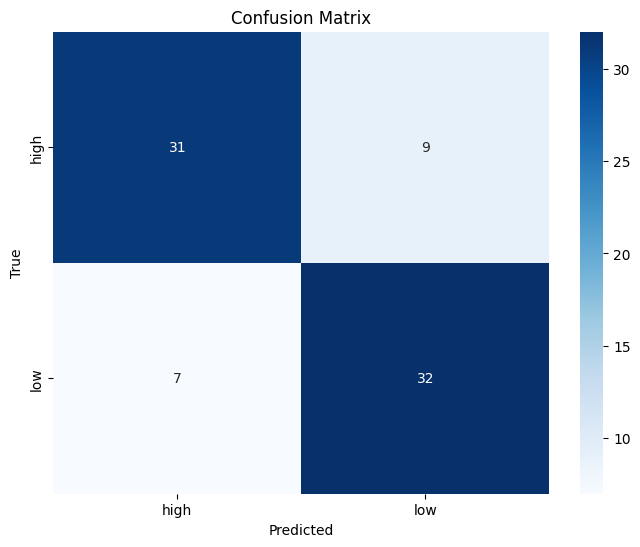

Precision: 0.7984
Recall: 0.7975
F1 Score: 0.7974
Accuracy: 0.7975
Class: high - Precision: 0.8158, Recall: 0.7750, F1: 0.7949
Class: low - Precision: 0.7805, Recall: 0.8205, F1: 0.8000


In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Function to compute predictions from the model
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions from the model
y_pred, y_true = get_predictions(pretrained_vit, test_dataloader_pretrained, device)

# Convert integer labels to string class names
y_true_classes = [class_names[i] for i in y_true]
y_pred_classes = [class_names[i] for i in y_pred]

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=class_names)

# Plot Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculating Precision, Recall, F1 Score, and Accuracy
precision = precision_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Display results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Optional: Per-class metrics
precision_per_class = precision_score(y_true_classes, y_pred_classes, average=None, zero_division=0)
recall_per_class = recall_score(y_true_classes, y_pred_classes, average=None, zero_division=0)
f1_per_class = f1_score(y_true_classes, y_pred_classes, average=None, zero_division=0)

for i, class_name in enumerate(class_names):
    print(f'Class: {class_name} - Precision: {precision_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, F1: {f1_per_class[i]:.4f}')


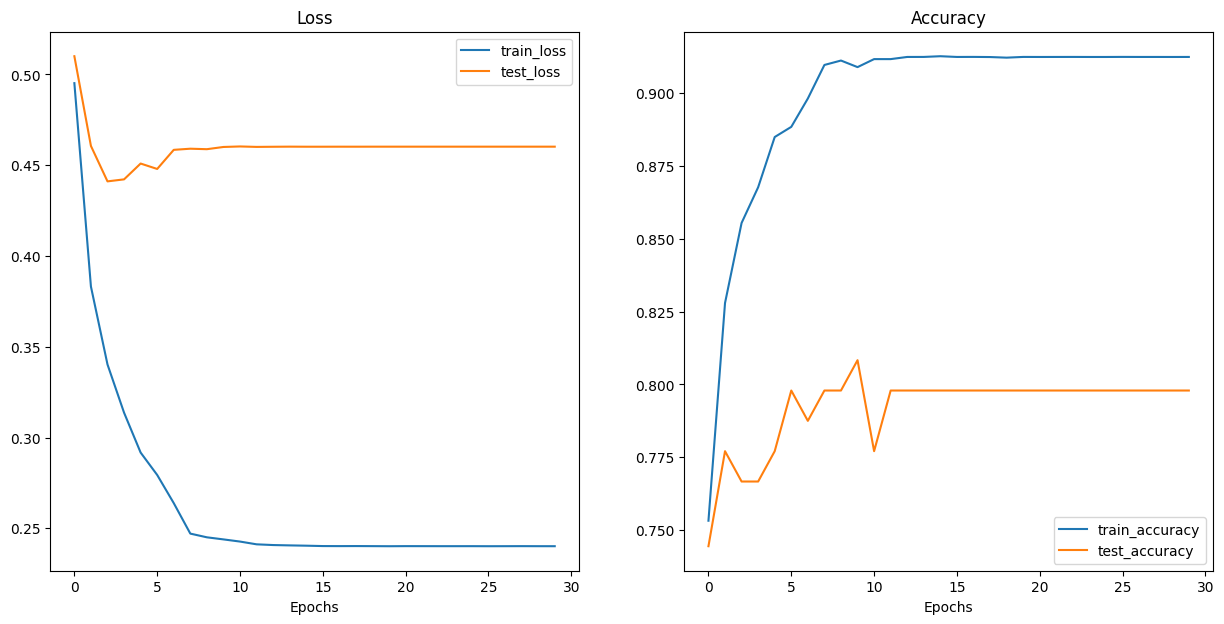

In [17]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

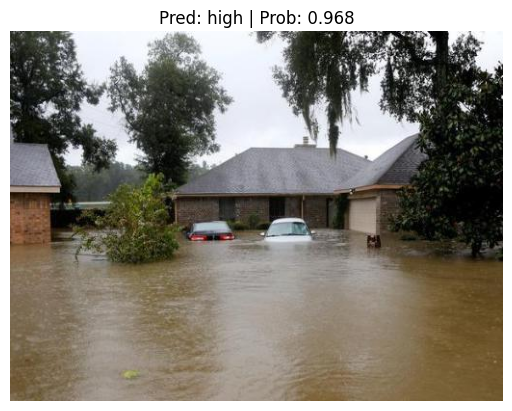

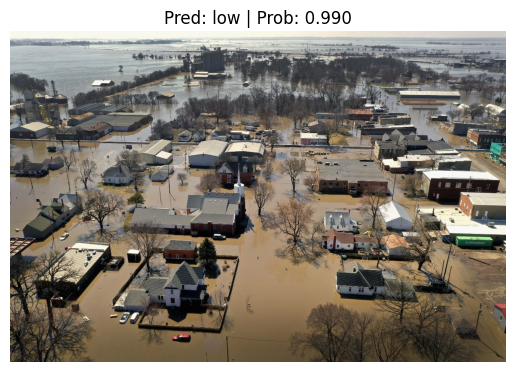

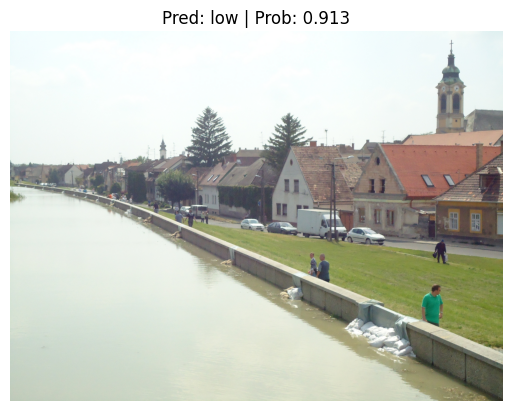

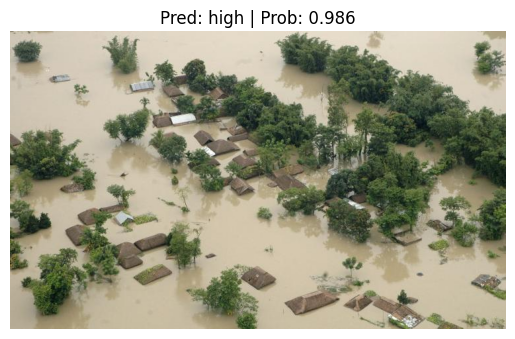

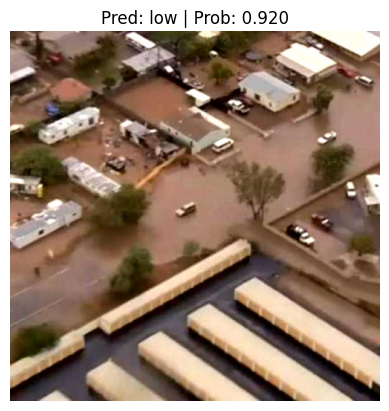

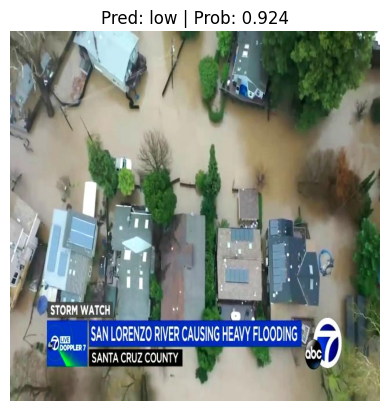

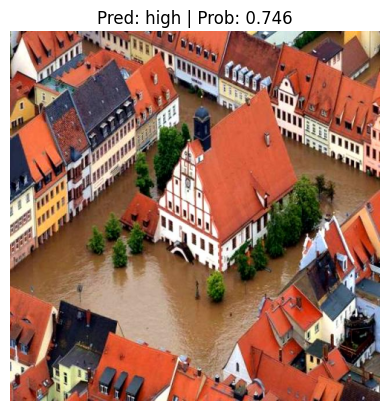

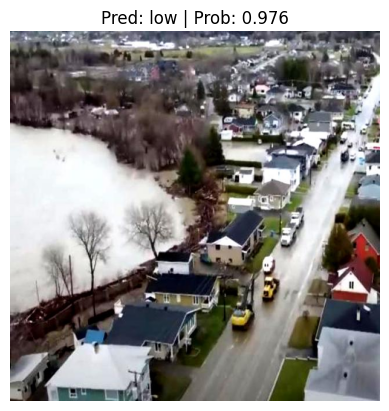

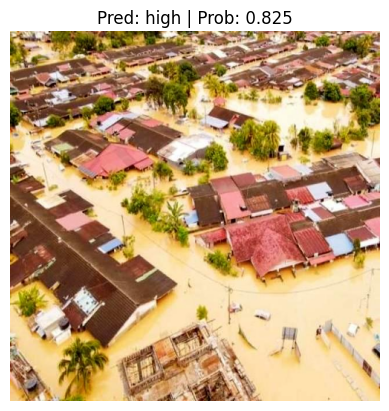

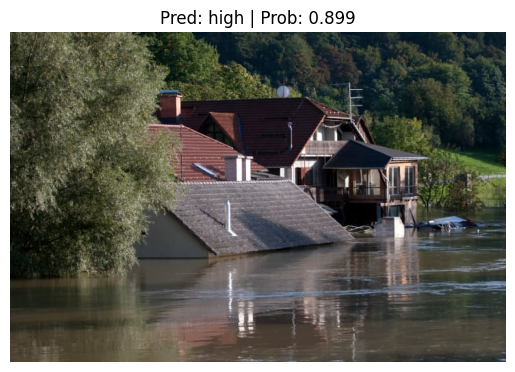

In [13]:
import os
from going_modular.going_modular.predictions import pred_and_plot_image



# Setup custom directory path
custom_image_directory = "/raid/home/minan/home/project/project/test"

# List all files in the directory
image_files = [f for f in os.listdir(custom_image_directory) if os.path.isfile(os.path.join(custom_image_directory, f))]

# Iterate over all image files and make predictions
for image_file in image_files:
    # Construct the full image path
    image_path = os.path.join(custom_image_directory, image_file)
    
    # Predict and plot the image
    pred_and_plot_image(model=pretrained_vit,
                        image_path=image_path,
                        class_names=class_names)

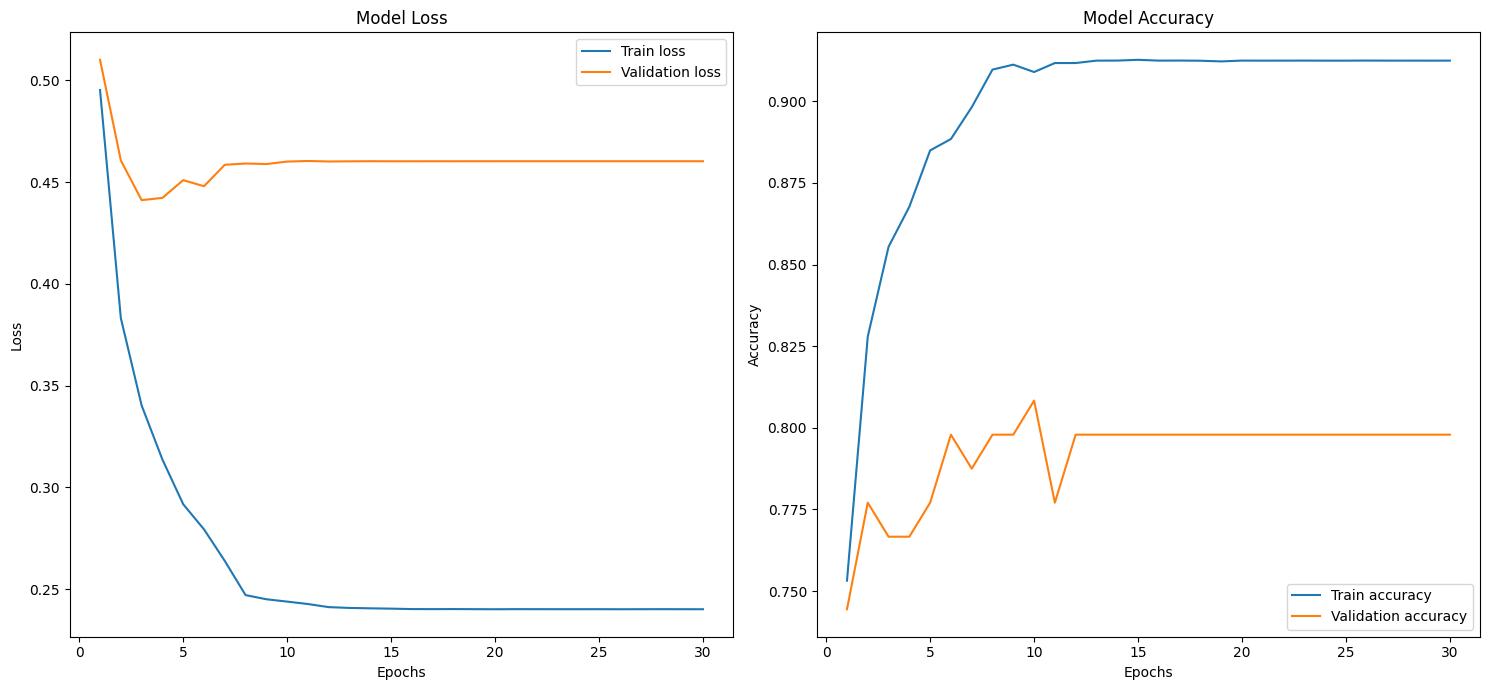

In [22]:
# Assuming you have these variables after training
train_losses = pretrained_vit_results['train_loss']
test_losses = pretrained_vit_results['test_loss']
train_accuracies = pretrained_vit_results['train_acc']
test_accuracies = pretrained_vit_results['test_acc']
epochs = 30  # Number of epochs

# Call the function to plot the loss and accuracy curves
plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, epochs)

In [21]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_loss, test_loss, train_acc, test_acc, epochs):
    """
    Plots the training and test loss and accuracy curves.

    Args:
        train_loss (list): List of training losses for each epoch.
        test_loss (list): List of test losses for each epoch.
        train_acc (list): List of training accuracies for each epoch.
        test_acc (list): List of test accuracies for each epoch.
        epochs (int): Number of epochs for the training process.
    """
    # Create subplots
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_loss, label="Train loss")
    plt.plot(range(1, epochs+1), test_loss, label="Validation loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_acc, label="Train accuracy")
    plt.plot(range(1, epochs+1), test_acc, label="Validation accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()
